# GMM Gym

Minimal working example of a GMM!

## 1. Setup

+ 1.1 Set up real deep parameters ($\lambda_0 = f(X, \theta)$)
+ 1.2 Get ValueF and optimal policy function
+ 1.3 Simulate demand and optimal pricing for N firms

## 2. Estimating $\theta$

Try $\theta$ until error < $\varepsilon$

+ 2.1. $\theta$ values generate a $\lambda_0$
+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions
+ 2.3. $error = \left|pricing decisions - observed pricing\right|$


## 1. Setup

In [3]:
import numpy as np
from typing import Callable
%matplotlib inline
import matplotlib.pyplot as plt
import dill
import numpy as np
import pandas as pd
    
import sys
sys.path.append('../')
import src

# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40

#Suitable for logistic
β10, β11 = -2, 3
β20, β21 = 0.03, -2.
betas = [β10, β11, β20, β21]


def lambda_0(x, prior_shock) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    return src.from_theta_to_lambda0(x, θ=betas, prior_shock=prior_shock)


def get_lambdas_from_x(xs, prior_shocks):
    y = np.empty((len(xs), 3))
    for i in range(len(xs)):
        y[i] = lambda_0(xs[i], prior_shocks[i])
    return y

xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
prior_shocks = src.gen_prior_shocks(Nfirms)
lambdas0 = get_lambdas_from_x(xs, prior_shocks)
lambdas0[0:10]



array([[0.19380724, 0.41133525, 0.5974515 ],
       [0.13175172, 0.49129519, 0.59313802],
       [0.24232809, 0.36508015, 0.59690646],
       [0.12161934, 0.50185056, 0.59303593],
       [0.13530413, 0.48279092, 0.59433247],
       [0.13762687, 0.47717382, 0.5951265 ],
       [0.16239783, 0.44493763, 0.59692397],
       [0.1252281 , 0.49991524, 0.592632  ],
       [0.13993298, 0.47683152, 0.59465323],
       [0.19032644, 0.41768444, 0.59676145]])

In [4]:
file_n = "2018-10-5vfi_dict.dill"
with open('../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


In [5]:
dmd_shocks = src.generate_dmd_shocks(n=Nfirms, t=time_periods, dmd_σϵ=src.const.σ_ɛ)

def many_runs(nfirms, **kwargs):
    dfs = []
    for firm_i in range(nfirms):
        df = src.simulate_one_firm(valueF, policyF,
                                   dmd_shocks=dmd_shocks[firm_i, :],
                                   prior_shock=prior_shocks[firm_i],
                                   x=xs[firm_i], θ=betas, **kwargs)
        df['firm'] = firm_i
        dfs.append(df)
        
    return pd.concat(dfs, axis=0)

df = many_runs(Nfirms)

## Estimating $\theta$

+ 2.1. $\theta$ values generate a $\lambda_0$

(defined aboved)

+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions

In [7]:
src.generate_pricing_decisions(policyF, np.array([0.2, 0.6, 0.2]),
                               df[df.firm == 15].log_dmd.values)[0:4]

array([2.32068966, 1.63795648, 1.29958781, 1.25893233])

+ 2.3. $error = \left|pricing decisions - observed pricing\right|$

+ Do I choose moments?

In [6]:
test_df = pd.DataFrame({'level_prices': [2., 3., 4., 1., 2.1, 2.1, 2.1, 2.5],
                       'firm': [0, 0, 0, 0, 0, 1, 1, 1],
                       't': [0, 1, 2, 3, 4, 0, 1, 2]})

test_df.groupby('firm')[['level_prices', 't']].rolling(window=3).std()

level_prices    t
firm                     
0    0           NaN  NaN
     1           NaN  NaN
     2      1.000000  1.0
     3      1.527525  1.0
     4      1.517674  1.0
1    5           NaN  NaN
     6           NaN  NaN
     7      0.230940  1.0

In [8]:
#Generate running std (to start)
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=3)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')

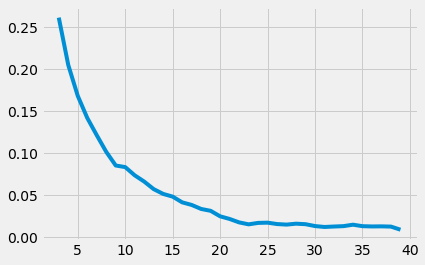

In [16]:


def generate_mean_std_pricing_decisions(policyF, lambdas_at_0, min_periods=3):
    """
    Lambdas0: starting priors for each of the N firms
    """
    pricing_decision_dfs = []
    for i, firm in enumerate(df.firm.unique()):
        prices = src.generate_pricing_decisions(policyF, lambdas_at_0[i],
                                       df[df.firm == firm].log_dmd.values)
        pricing_decision_dfs.append(pd.DataFrame({'level_prices': prices,
                                    'firm': np.repeat(firm, len(prices))
                                  }))
        
    pricing_decision_df = pd.concat(pricing_decision_dfs, axis=0)
                                        
                                        
    std_dev_df = (pricing_decision_df.groupby('firm').level_prices.rolling(window=4,
                                                            min=min_periods)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))
    
    return std_dev_df.groupby('t').std_dev_prices.mean()[min_periods:]
                                        
                              
                                        
avers = generate_mean_std_pricing_decisions(policyF, lambdas_at_0=lambdas0)
plt.style.use('fivethirtyeight')
plt.plot(avers)

In [18]:
df.columns

Index(['level_prices', 'log_dmd', 'valueF', 'lambda1', 'lambda2', 'lambda3',
       't', 'firm', 'std_dev_prices'],
      dtype='object')

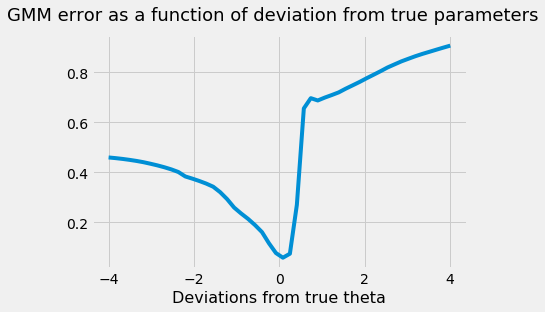

In [25]:
#@njit()
def from_theta_to_lambda_for_all_firms(θ, xs, prior_shocks=prior_shocks):
    nfirms = len(xs)
    lambdas0 = np.empty((nfirms, 3))
    for firm_i in range(nfirms):
        lambdas0[firm_i, :] = src.from_theta_to_lambda0(xs[i], θ,
                                                       prior_shocks[i])

    return lambdas0
    
def std_moments_error(θ: np.ndarray, policyF,
                      xs,
                      mean_std_observed_prices, min_periods=3,
                     df=None) -> float:
    """
    Computes the norm of the different between the observed moments and
    the moments predicted by the model + θ
    
    Moments: average (over firms) standard deviation for each time period
    
    x: characteristics of firms
    mean_std_observed_prices: mean (over firms) of standard deviation per t
    """
    #CHANGE THIS: Loop over different Xs! Each firm should have its own X
    # Generate one lambda0 per firm
    lambdas0 = from_theta_to_lambda_for_all_firms(θ, xs)
    
    mean_std_expected_prices = generate_mean_std_pricing_decisions(policyF,
                                                lambdas0, min_periods)
    
    return np.linalg.norm(mean_std_expected_prices.values 
                          - mean_std_observed_prices.values)

min_periods = 3

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

real_theta = np.array([-2, 3, 0.03, -2])

error = []
deviation = np.linspace(-4, 4, 50)
thetas = real_theta + deviation[:, np.newaxis]

for theta in thetas:
    error.append(std_moments_error(theta, policyF, xs, mean_std_observed_prices,
                 min_periods=3))
    
fig, ax = plt.subplots(1, 1)
ax.plot(deviation, error)
ax.set_xlabel("Deviations from true theta", size=16)
fig.suptitle("GMM error as a function of deviation from true parameters", size=18);

1.2999150967298112 1.2869394664881244 1.1539347845185266


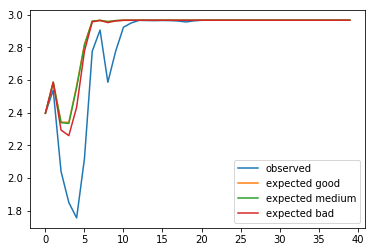

In [136]:
def error(θ: np.ndarray, x, observed_log_dmd, observed_prices) -> float:
    lambda0 = from_theta_to_lamba0(θ, x)
    expected_prices = generate_pricing_decisions(lambda0, observed_log_dmd)
    return np.linalg.norm(expected_prices - observed_prices)


firm_id = 90
chosen_x = xs[firm_id]
chosen_dmd = df[df.firm == firm_id].log_dmd.values
chosen_prices = df[df.firm == firm_id].level_prices.values


def error_diagnostic(θ, x, observed_log_dmd, observed_prices):
    lambda0 = from_theta_to_lamba0(θ, x)
    expected_prices = generate_pricing_decisions(lambda0, observed_log_dmd)
    return observed_prices, expected_prices, np.linalg.norm(expected_prices - observed_prices)

def error_w_data(θ) -> float:
    return error(θ, chosen_x, chosen_dmd, chosen_prices)


trueθ0 = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+0.3, β11-0.05, β20+0.1, β21-0.05])
obs_pr, exp_pr, norm1 = error_diagnostic(trueθ0, chosen_x, chosen_dmd, chosen_prices)
obs_prmedium, exp_prmedium, norm2 = error_diagnostic(mediumθ0, chosen_x, chosen_dmd, chosen_prices)
obs_prbad, exp_prbad, norm3 = error_diagnostic(badθ0, chosen_x, chosen_dmd, chosen_prices)

print(norm1, norm2, norm3)
fig, ax = plt.subplots(1, 1)
ax.plot(obs_pr, label='observed')
ax.plot(exp_pr, label="expected good")
ax.plot(exp_prmedium, label="expected medium")
ax.plot(exp_prbad, label="expected bad")
ax.legend();

## 3. Optimize

## Optimize with moments

In [26]:
min_periods = 3

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

def error_w_data(θ):
    return std_moments_error(θ, policyF, xs,
                      mean_std_observed_prices=mean_std_observed_prices,
                             min_periods=3)



In [28]:
trueθ0 = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+0.3, β11-0.05, β20+0.1, β21-0.05])
trueθ0

array([-2.  ,  3.  ,  0.03, -2.  ])

In [29]:
badθ0

array([-1.7 ,  2.95,  0.13, -2.05])

In [ ]:
array([ 5.29954226e-03, -1.02871296e+01,  2.48956659e+00, -1.67859115e+01

In [32]:
from scipy import optimize as opt
true_params = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+2, β11-1, β20+1, β21-3])

opt.minimize(error_w_data, badθ0,
             method='Nelder-Mead', options={'maxiter': 100, 'disp': True})

 final_simplex: (array([[ 5.29954226e-03, -1.02871296e+01,  2.48956659e+00,
        -1.67859115e+01],
       [ 5.29953737e-03, -1.02871300e+01,  2.48956580e+00,
        -1.67859118e+01],
       [ 5.29953842e-03, -1.02871296e+01,  2.48956610e+00,
        -1.67859126e+01],
       [ 5.29954718e-03, -1.02871302e+01,  2.48956817e+00,
        -1.67859116e+01],
       [ 5.29955079e-03, -1.02871298e+01,  2.48956906e+00,
        -1.67859073e+01]]), array([0.54721217, 0.5472142 , 0.54722698, 0.54749134, 0.54752757]))
           fun: 0.547212174134108
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 213
           nit: 100
        status: 2
       success: False
             x: array([ 5.29954226e-03, -1.02871296e+01,  2.48956659e+00, -1.67859115e+01])

In [ ]:
import time
start = time.time()
maxiters=3
opt.differential_evolution(error_w_data, [(-3, 3), (-3, 3), (-3, 3), (-3, 3)],
                          maxiter=maxiters)

time_taken = start/60 - time.time()/60
print("Taken {0} minutes for {1} iterations. {2} per iteration".format(
      time_taken, maxiters, time_taken/maxiters))


## Nelder-Mead

Doesn't converge. Not super surprised, since the problem is weird

In [141]:
from scipy import optimize as opt
#minimize(f, x0,, method='Nelder-Mead')
true_params = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+2, β11-1, β20+1, β21-3])
opt.minimize(error_w_data, badθ0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})

 final_simplex: (array([[ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00]]), array([1.91533241, 1.9243984 , 1.9332215 , 1.93347883, 1.93582771]))
           fun: 1.9153324053720298
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 13571
           nit: 5000
        status: 2
       success: False
             x: array([ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00, -4.99999927e+00])

## Differential Evolution

Does converge! Seems promising even though it's slow

In [144]:
opt.differential_evolution(error_w_data, [(-3, 3), (-3, 3), (-3, 3), (-3, 3)],
                          maxiter=1000)

     fun: 0.048427970155213274
 message: 'Optimization terminated successfully.'
    nfev: 7965
     nit: 130
 success: True
       x: array([-1.36566532,  0.48591431,  0.67631488, -2.59839081])